# Avaliação Final - Introdução Ciência de Dados

#### Aluno: Benicio R. Magalhães

In [1]:
#import das bibliotecas e modelos
import csv
import math 
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.svm import SVC
from sklearn import datasets
from statistics import variance
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


random.seed(42)

# Pré-processamento
    01.leitura dos dados
    02.identifcação de outliers e limpeza dos dados
    03.transformação
    04.normalização ou padronização
    05.conjunto de treinamento e conjunto de testes
    06.analise descritiva dos dados

In [2]:
# 01.leitura dos dados

data = pd.read_csv('data/winequality-red.csv')
print('linhas, colunas: ', data.shape)
data.head(5)

linhas, colunas:  (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
# 02.identifcação de outliers e limpeza dos dados

#criando uma função para detectar outliers usando o método do IQR, se encontrar outlier, substitui por um NaN
def detect_outlier(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3-Q1
    mask = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    data[mask] = np.nan
    return data

#colocando os dados de quality em uma série separada, para não aplicar o método de IQR 
s_quality = pd.Series(data['quality']).to_frame()

#realizando drop de quality
data.drop(['quality'],axis = 1, inplace = True)

#identificando os outliers no restante da base de dados
data = detect_outlier(data)

#verificando as ocorrências de NaN depois de identificar os outliers
data.isnull().sum().sort_values(ascending=False).head(12)

residual sugar          155
chlorides               112
sulphates                59
total sulfur dioxide     55
fixed acidity            49
density                  45
pH                       35
free sulfur dioxide      30
volatile acidity         19
alcohol                  13
citric acid               1
dtype: int64

In [4]:
#substituindo as ocorrências de NaN pelas médias
averages = data.mean(axis=0)
nrow,ncol = data.shape
for i in range(0,nrow):
    for j in range(0,ncol):
        if(np.isnan(data.iloc[i,j]) == True):
            data.iloc[i,j] = averages[j]
            
#verificando as ocorrências de NaN depois da substituição
data.isnull().sum().sort_values(ascending=False).head(12)

alcohol                 0
sulphates               0
pH                      0
density                 0
total sulfur dioxide    0
free sulfur dioxide     0
chlorides               0
residual sugar          0
citric acid             0
volatile acidity        0
fixed acidity           0
dtype: int64

In [5]:
# 03.transformação

#convertendo a serie quality em binario, onde valor maior que 6.5 é bom e menor é ruim
mask_ruim = (s_quality < 6.5)
s_quality[mask_ruim] = 0

mask_bom = (s_quality > 6.5)
s_quality[mask_bom] = 1

#inserindo a serie quality novamente no data frame pós tratamento dos outliers
data = pd.concat([data,s_quality],axis=1)

#aplicando o one-hot encoding nos dados, se for o caso
data = pd.get_dummies(data)

#convertendo para numpy
data_convert = data.to_numpy()
nrow,ncol = data_convert.shape
y = data_convert[:,-1]
X = data_convert[:,0:(ncol-1)]

In [6]:
# 04.normalização ou padronização

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [7]:
# 05.conjunto de treinamento e conjunto de testes (80/20)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

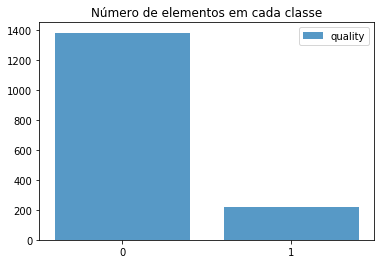

In [8]:
# 06.analise descritiva dos dados

#balanceamento das classes
classes = data[data.columns[-1]]
cl = np.unique(classes)
ncl = np.zeros(len(cl))
for i in np.arange(0, len(cl)):
    a = classes == cl[i]
    ncl[i] = len(classes[a])
    
numbers = np.arange(0, len(cl))
plt.bar(numbers, ncl,  alpha=.75, label='quality')
plt.xticks(numbers, cl)
plt.title('Número de elementos em cada classe')
plt.legend()
plt.show(True)

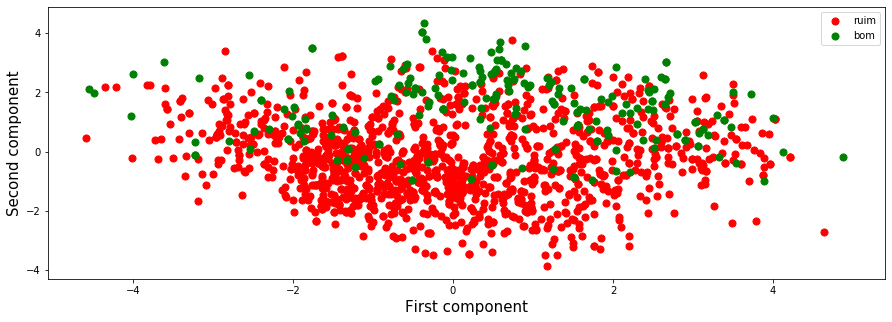

In [9]:
#aplicando PCA para separação de classes

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

colors = ['r', 'g', 'b']
aux = 0
plt.figure(figsize=(15,5))

#considerando todas as classificações igual a um como bom e igual a zero como ruim.
for c in cl:
    if c == 1:
        lb = 'bom'
    else:
        lb = 'ruim'
    nodes = np.where(y == c)
    plt.scatter(pca_result[nodes,0], pca_result[nodes,1], s=50, color = colors[aux], label = lb)
    aux = aux + 1
plt.legend()
plt.xlabel("First component", fontsize=15)
plt.ylabel("Second component", fontsize=15)
plt.xticks(color='k', size=10)
plt.yticks(color='k', size=10)
plt.show(True)

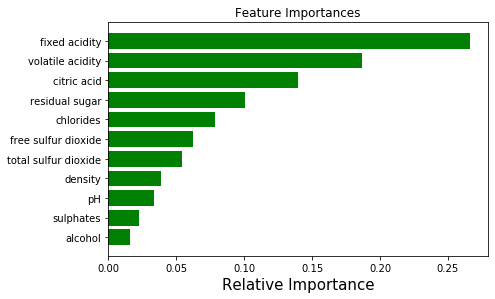

In [10]:
#atributos que mais explicam a variância dos dados

pca = PCA()
pca_result = pca.fit_transform(X)
var_exp = pca.explained_variance_ratio_

importances = var_exp
attributes = data.columns[0:(len(data.columns)-1)]
indices = np.argsort(importances)
attributes_rank = []
for i in indices:
    attributes_rank.append(attributes[i])
plt.title('Feature Importances')
plt.tight_layout()
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), attributes_rank, fontsize=25)
plt.xlabel('Relative Importance',fontsize=15)
plt.xticks(color='k', size=10)
plt.yticks(color='k', size=10)
plt.show()

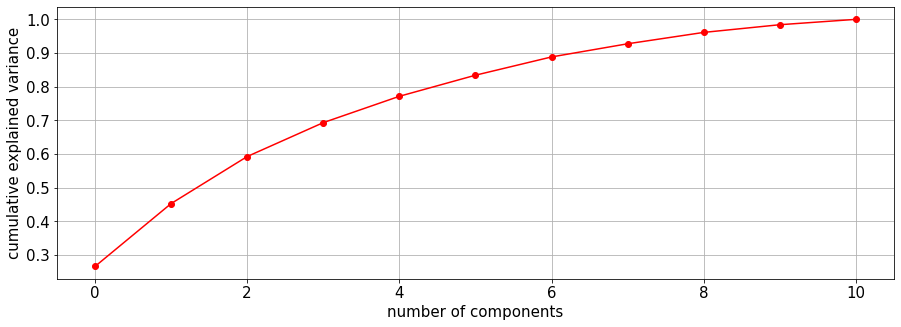

In [11]:
#mudança da variância conforme número de componentes

pca = PCA().fit(X)
plt.figure(figsize=(15,5))
ncomp = np.arange(0, np.shape(X)[1])
plt.plot(ncomp, np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.xlabel('number of components', fontsize=15)
plt.ylabel('cumulative explained variance', fontsize=15);
plt.xticks(color='k', size=15)
plt.yticks(color='k', size=15)
plt.grid(True)
plt.show(True)

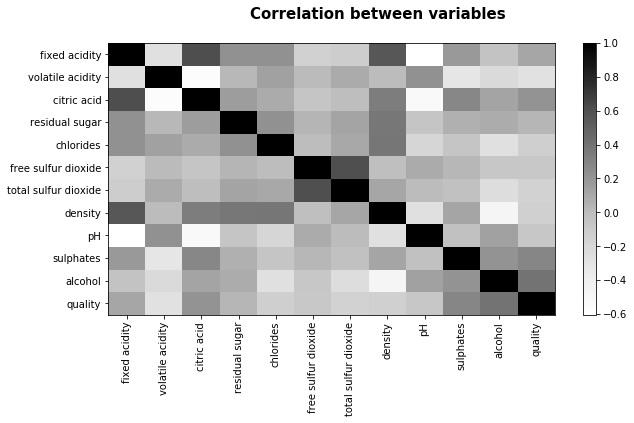

In [12]:
#matriz de correlação

corr = data.corr()
plt.figure(figsize=(10, 5))
plt.imshow(corr, cmap='Greys', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr)), corr.columns);
plt.suptitle('Correlation between variables', fontsize=15, fontweight='bold')
plt.grid(False)
plt.show()

# Classificação
    01.Kvizinhos
    02.Árvore de decisão
    03.Naive Bayes
    04.SVM
    05.Random Forest

Melhor k: 1  AUC: 0.767517132539028


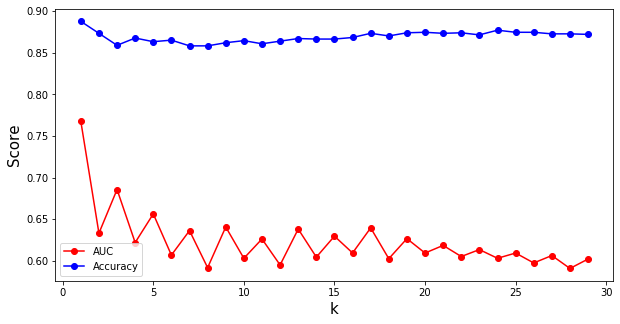

In [13]:
# 01.Kvizinhos

cv_knn = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
mauc_knn = []
macc_knn = []
vk = []
for k in range(1, 30):
    vauc_knn = []
    vacc_knn = []
    for train_index, test_index in cv_knn.split(X, y):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model_knn = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
        model_knn.fit(x_train,y_train)
        y_pred_knn = model_knn.predict(x_test) 
        score = accuracy_score(y_pred_knn, y_test)
        vauc_knn.append(roc_auc_score(y_test, y_pred_knn))
        vacc_knn.append(accuracy_score(y_pred_knn, y_test))
    macc_knn.append(np.mean(vacc_knn))
    mauc_knn.append(np.mean(vauc_knn))
    vk.append(k)
    
best_k = np.argmax(mauc_knn)+1
print('Melhor k:', best_k, ' AUC:',mauc_knn[best_k-1])
plt.figure(figsize=(10,5))
plt.plot(vk, mauc_knn, '-ro', label= 'AUC')
plt.plot(vk, macc_knn, '-bo', label = 'Accuracy')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.legend()
plt.show()

In [14]:
#aplicando o modelo para o melhor k

model_KNN = KNeighborsClassifier(n_neighbors=best_k, metric = 'euclidean')
model_KNN.fit(x_train,y_train)
y_pred_KNN = model_KNN.predict(x_test) 
score = accuracy_score(y_pred_KNN, y_test)

print('--------------Kvizinhos--------------')
print('Accuracy:', '%.2f' % accuracy_score(y_test, y_pred_KNN))
print('F1 score:', '%.2f' % f1_score(y_test, y_pred_KNN, average="macro"))
print('Precision:', '%.2f' % precision_score(y_test, y_pred_KNN, average="macro"))
print('Recall:', '%.2f' % recall_score(y_test, y_pred_KNN, average="macro"))

--------------Kvizinhos--------------
Accuracy: 0.90
F1 score: 0.78
Precision: 0.78
Recall: 0.78


In [15]:
# 02.Árvore de decisão

model_DTC = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=42)
model_DTC.fit(x_train,y_train)
y_pred_DTC = model_DTC.predict(x_test) 

print('--------------Árvore de decisão--------------')
print('Accuracy:', '%.2f' % accuracy_score(y_test, y_pred_DTC))
print('F1 score:', '%.2f' % f1_score(y_test, y_pred_DTC, average="macro"))
print('Precision:', '%.2f' % precision_score(y_test, y_pred_DTC, average="macro"))
print('Recall:', '%.2f' % recall_score(y_test, y_pred_DTC, average="macro"))

--------------Árvore de decisão--------------
Accuracy: 0.90
F1 score: 0.79
Precision: 0.78
Recall: 0.80


In [16]:
# 03.Naive Bayes

model_NBC = GaussianNB()
model_NBC.fit(x_train,y_train)
y_pred_NBC = model_NBC.predict(x_test)

print('--------------Naive Bayes--------------')
print('Accuracy:', '%.2f' % accuracy_score(y_test, y_pred_NBC))
print('F1 score:', '%.2f' % f1_score(y_test, y_pred_NBC, average="macro"))
print('Precision:', '%.2f' % precision_score(y_test, y_pred_NBC, average="macro"))
print('Recall:', '%.2f' % recall_score(y_test, y_pred_NBC, average="macro"))

--------------Naive Bayes--------------
Accuracy: 0.85
F1 score: 0.70
Precision: 0.68
Recall: 0.71


Melhor c: 29  AUC: 0.7545803560426644


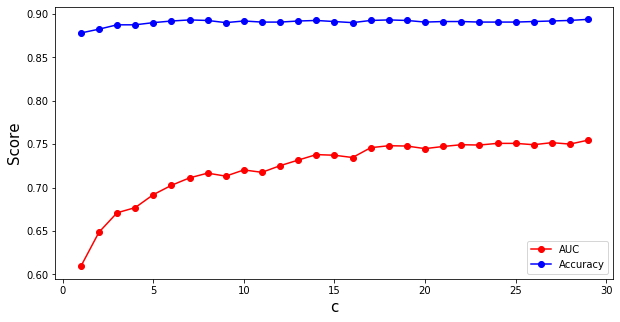

In [17]:
# 04.SVM

cv_svm = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
mauc_svm = []
macc_svm = []
vc = []
for c in range(1, 30):
    vauc_svm = []
    vacc_svm = []
    for train_index, test_index in cv_svm.split(X, y):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model_svm = SVC(C = c, gamma = 'auto')
        model_svm.fit(x_train,y_train)
        y_pred_svm = model_svm.predict(x_test) 
        score = accuracy_score(y_pred_svm, y_test)
        vauc_svm.append(roc_auc_score(y_test, y_pred_svm))
        vacc_svm.append(accuracy_score(y_pred_svm, y_test))
    macc_svm.append(np.mean(vacc_svm))
    mauc_svm.append(np.mean(vauc_svm))
    vc.append(c)

best_c = np.argmax(mauc_svm)+1
print('Melhor c:', best_c, ' AUC:',mauc_svm[best_c-1])
plt.figure(figsize=(10,5))
plt.plot(vc, mauc_svm, '-ro', label= 'AUC')
plt.plot(vc, macc_svm, '-bo', label = 'Accuracy')
plt.xlabel('c', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.legend()
plt.show()

In [18]:
#aplicando o modelo para o melhor c

model_SVM = SVC(C = best_c, gamma = 'auto',random_state=42)
model_SVM.fit(x_train,y_train)
y_pred_SVM = model_SVM.predict(x_test)

print('--------------SVM--------------')
print('Accuracy:', '%.2f' % accuracy_score(y_test, y_pred_SVM))
print('F1 score:', '%.2f' % f1_score(y_test, y_pred_SVM, average="macro"))
print('Precision:', '%.2f' % precision_score(y_test, y_pred_SVM, average="macro"))
print('Recall:', '%.2f' % recall_score(y_test, y_pred_SVM, average="macro"))

--------------SVM--------------
Accuracy: 0.94
F1 score: 0.87
Precision: 0.88
Recall: 0.87


Melhor n: 10  AUC: 0.7446796712827366


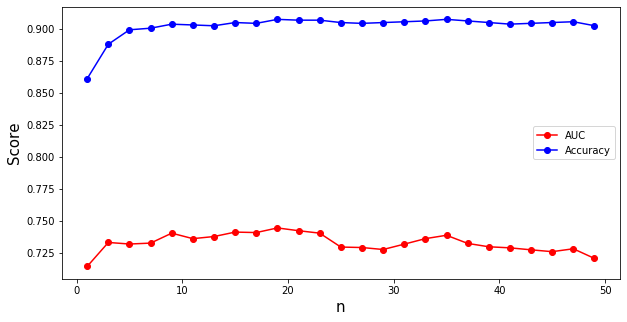

In [19]:
# 05.Random Forest

cv_rfc = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
mauc_rfc = []
macc_rfc = []
vn = []
for n in range(1, 50,2):
    vauc_rfc = []
    vacc_rfc = []
    for train_index, test_index in cv_rfc.split(X, y):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model_rfc = RandomForestClassifier(n_estimators=n, random_state=42)
        model_rfc.fit(x_train,y_train)
        y_pred_rfc = model_rfc.predict(x_test) 
        score = accuracy_score(y_pred_rfc, y_test)
        vauc_rfc.append(roc_auc_score(y_test, y_pred_rfc))
        vacc_rfc.append(accuracy_score(y_pred_rfc, y_test))
    macc_rfc.append(np.mean(vacc_rfc))
    mauc_rfc.append(np.mean(vauc_rfc))
    vn.append(n)
best_n = np.argmax(mauc_rfc)+1
print('Melhor n:', best_n, ' AUC:',mauc_rfc[best_n-1])
plt.figure(figsize=(10,5))
plt.plot(vn, mauc_rfc, '-ro', label= 'AUC')
plt.plot(vn, macc_rfc, '-bo', label = 'Accuracy')
plt.xlabel('n', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.legend()
plt.show()

In [20]:
#aplicando o modelo para o melhor n

model_RFC =RandomForestClassifier(n_estimators=best_n, bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_jobs=1,
            oob_score=False, random_state=42, verbose=0,
            warm_start=False)

model_RFC.fit(x_train,y_train)
y_pred_RFC = model_RFC.predict(x_test)

print('--------------Random Forest--------------')
print('Accuracy:', '%.2f' % accuracy_score(y_test, y_pred_RFC))
print('F1 score:', '%.2f' % f1_score(y_test, y_pred_RFC, average="macro"))
print('Precision:', '%.2f' % precision_score(y_test, y_pred_RFC, average="macro"))
print('Recall:', '%.2f' % recall_score(y_test, y_pred_RFC, average="macro"))

--------------Random Forest--------------
Accuracy: 0.92
F1 score: 0.79
Precision: 0.92
Recall: 0.73


# Ordenação de atributos
    01.ordenando os atributos do random forest

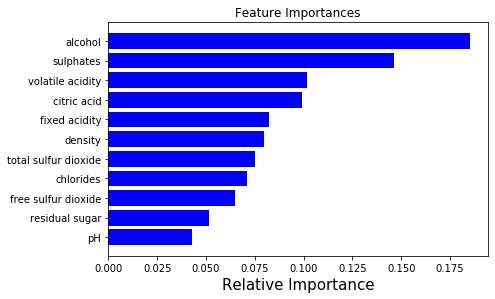

In [21]:
# 01.ordenando os atributos do random forest

importances_rfc = model_RFC.feature_importances_
attributes_rfc = data.columns[0:(len(data.columns)-1)]
indices_rfc = np.argsort(importances_rfc)
attributes_rank_rfc = []
for i in indices_rfc:
    attributes_rank_rfc.append(attributes_rfc[i])
plt.title('Feature Importances')
plt.tight_layout()
plt.barh(range(len(indices_rfc)), importances_rfc[indices_rfc], color='b', align='center')
plt.yticks(range(len(indices_rfc)), attributes_rank_rfc, fontsize=25)
plt.xlabel('Relative Importance',fontsize=15)
plt.xticks(color='k', size=10)
plt.yticks(color='k', size=10)
plt.show()

# Regressão
    01.regressão linear para predizer a porcentagem de álcool
    02.comparação entre método Lasso e Ridge Regression com erro quadrático médio

In [22]:
# 01.regressão linear para predizer a porcentagem de álcool

#definindo os dados para regressão, alcohol como variável alvo
y_regression = data['alcohol']

#coniderando todos os outros atributos na regressão.
x_regression = data.drop(['alcohol'],axis = 1, inplace=False)

#convertendo para numpy
y_regression_np = y_regression.to_numpy()
x_regression_np = x_regression.to_numpy()

#definindo conjunto de treino e conjunto de testes
p = 0.2
x_regression_train, x_regression_test, y_regression_train, y_regression_test = train_test_split(x_regression_np, y_regression_np, test_size = p, random_state = 42)

R2: 0.57
RSME: 0.48


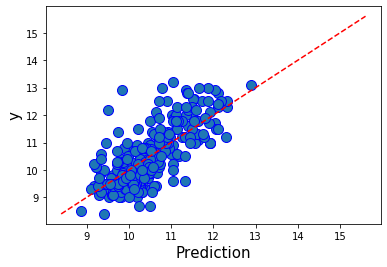

In [23]:
#aplicando o modelo de regressão linear múltipla, calculando R2 e plotando os resultados

lm = LinearRegression()
lm.fit(x_regression_train, y_regression_train)
y_pred_lm = lm.predict(x_regression_test)

l = plt.plot(y_pred_lm, y_regression_test, 'bo')
plt.setp(l, markersize=10)
plt.setp(l, markerfacecolor='C0')

plt.ylabel("y", fontsize=15)
plt.xlabel("Prediction", fontsize=15)

# mostra os valores preditos e originais
xl = np.arange(min(y_regression_test), 1.2*max(y_regression_test),(max(y_regression_test)-min(y_regression_test))/10)
yl = xl
plt.plot(xl, yl, 'r--')

#calculando o R2 score
R2 = r2_score(y_regression_test, y_pred_lm)
print('R2:', '%.2f' % R2)
#calculando o erro quadrático médio para a regressão linear múltipla
RSME = mean_squared_error(y_regression_test, y_pred_lm)
print("RSME:", '%.2f' % RSME)

plt.show(True)

In [24]:
# 02.comparação entre método Lasso e Ridge Regression com erro quadrático médio

#ridge regression, o RSME para alpha zero deve ser igual ao encontrado na regressão linear múltipla
ridge2 = Ridge(alpha = 0, normalize = True)
ridge2.fit(x_regression_train, y_regression_train)  
y_pred_ridge = ridge2.predict(x_regression_test)           

#calculando o erro quadrático médio para o ridge regression
RSME = mean_squared_error(y_regression_test, y_pred_ridge)
print("RSME:", '%.2f' % RSME)

RSME: 0.48


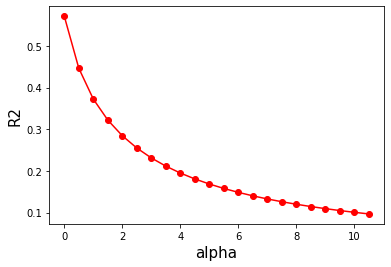

In [25]:
#verificando variação do coeficiente R2 de acordo com a variação de alpha pelo ridge regression

vR2 = []
valpha = []
for alpha in np.arange(0,11,0.5):
    ridge2 = Ridge(alpha = alpha, normalize = True)
    ridge2.fit(x_regression_train, y_regression_train)             
    y_pred_rr = ridge2.predict(x_regression_test)
    r2 = r2_score(y_regression_test, y_pred_rr)
    vR2.append(r2)
    valpha.append(alpha)
plt.plot(valpha, vR2, '-ro')
plt.xlabel("alpha", fontsize=15)
plt.ylabel("R2", fontsize=15)
plt.show(True)

In [26]:
#LASSO

lasso = Lasso(alpha=0.001,normalize=True, max_iter=1e5)
lasso.fit(x_regression_train, y_regression_train)           
y_pred_lasso = lasso.predict(x_regression_test)   

RSME_lasso = mean_squared_error(y_regression_test, y_pred_lasso)         
print('RSME:', '%.2f' % RSME_lasso)

RSME: 0.52


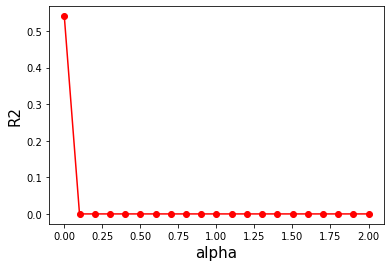

In [27]:
#verificando variação do coeficiente R2 de acordo com a variação de alpha pelo método lasso

vR2 = []
valpha = []
for alpha in np.arange(0.001,2.1,0.1):
    lasso_a = Lasso(alpha = alpha, normalize = True)
    lasso_a.fit(x_regression_train, y_regression_train)             
    y_pred_lasso_a = lasso_a.predict(x_regression_test)           
    r2 = r2_score(y_regression_test, y_pred_lasso_a)
    vR2.append(r2)
    valpha.append(alpha)
plt.plot(valpha, vR2, '-ro')
plt.xlabel("alpha", fontsize=15)
plt.ylabel("R2", fontsize=15)
plt.show(True)

In [28]:
#verificando atributos mais importantes, se algum atributo apresenta coeficiente zero, ele não contribui para a regressão

lasso = Lasso(alpha = 0.01, normalize = True)
lasso.fit(x_regression_train, y_regression_train) 
features = x_regression.columns[0:(len(x_regression.columns))]
dic = dict(zip(features,lasso.coef_))

print(dic)
print()
print('Os atributos density e quality são os que mais influenciam na predição de alcohol.')

{'fixed acidity': -0.0, 'volatile acidity': -0.0, 'citric acid': 0.0, 'residual sugar': 0.0, 'chlorides': -0.0, 'free sulfur dioxide': -0.0, 'total sulfur dioxide': -0.0, 'density': -55.146922170797104, 'pH': 0.0, 'sulphates': 0.0, 'quality': 0.0931080328147085}

Os atributos density e quality são os que mais influenciam na predição de alcohol.


# Conclusão
    01.discussão de resultados - pré-processamento
    02.discussão de resultados - classificação
    03.discussão de resultados - ordenação dos atributos
    04.discussão de resultados - regressão

###### 01. discussão de resultados - pré-processamento

Na sessão de pré-processamento, foi realizada uma identificação de outliers através do método de interquartil IQR. Neste caso, os valores mapeados como outlier foram substituidos pelas suas respectivas médias. 

Com relação aos dados sobre a qualidade do vinho (atributo em estudo) foi feita uma classificação dos valores entre bom e ruim, transformando os resultados da avaliação, que era um score de 0 à 10, em uma variável dicotômica. Foi considerado que vinhos com qualidade maior que 6.5 são bons e abaixo disso, ruins.

Com relação à divisão dos dados em conjunto de treinamento e conjunto de testes, foi definida 80% para treinamento e 20% para testes.

Foi apresentada também uma análise descritiva dos dados, onde foi observado que:
    * As classes estão desbalanceadas. Exite muito mais vinhos classificados como ruins do que como bons.
    * Na separação de classes usando PCA, não é possível observar regiões claras de separação para a qualidade do vinho.
    * Observa-se que seis componentes são suficientes para explicar 90% da variância dos dados.

###### 02. discussão de resultados - classificação

Considerando a seguinte matriz de confusão para o problema da classificação dos vinhos, temos:
    * Verdadeiro Positivo (VP) = Vinho detectado como bom, sendo realmente bom.
    * Verdadeiro Negativo (VN) = Vinho detectado como ruim, sendo realmente ruim.
    * Falso Positivo (FP) = Vinho detectado como bom, sendo ruim.
    * Falso Negativo (FN) = Vinho detectado como ruim, sendo bom.

Premissa considerada para análise: FN é mais prejudicial que um FP, pois safras de ótima qualidade são difíceis de serem encontradas e, caso o modelo classifique como ruim uma safra boa, o prejuízo comercial pode ser grande, considerando que elas seriam comercializadas por um preço muito menor.

Verificando os processos de classificação, o SVM e o Random Forest apresentaram os melhores resultados:

<b><font color='red'>--------------SVM--------------</font></b><br>
<b>Accuracy: 0.94</b><br>
F1 score: 0.87<br>
Precision: 0.88<br>
<b>Recall: 0.87</b><br>

<b><font color='red'>--------------Random Forest--------------</font></b><br>
<b>Accuracy: 0.92</b><br>
F1 score: 0.79<br>
Precision: 0.92<br>
<b>Recall: 0.73</b><br>

Além do SVM apresentar uma acurácia um pouco maior, será levado em consideração que o recall apresentado foi bem maior do que no Random Forest. O recall pode ser utilizado nas situações em que FN são considerados mais prejudiciais que FP, portanto, um modelo com alto recall minimiza os erros de classificação de um vinho de excelente qualidade como sendo ruim.<br><br>
<b>Portanto, o SVM foi o método de classificação que obteve os melhores resultados, dada a premissa estabelecida.</b>

###### 03.discussão de resultados - ordenação dos atributos

Dada a possibilidade de ordenar os atributos de acordo com sua importância, os resultados obtidos para o random forest mostraram que o álcool é o principal atributo para a classificação de uma safra. Como visto no gráfico da mudança de variância versus número de atributos, 6 componentes já explicam 90% dos dados, portanto, em um caso onde haja necessidade de selecionar os principais atributos para a classificação dos vinhos é possível elencá-los da seguinte forma:

    1) alcohol
    2) sulphates
    3) volatile acidity
    4) citric acid
    5) fixed acidity
    6) density

###### 04.discussão de resultados - regressão

Realizando uma regressão linear múltipla para predizer a porcentagem de álcool, o modelo apresentou um R2 de 0.57, ou seja, o efeito causal das demais variáveis sobre o fator do álcool é um pouco maior que 50%. O RSME obtido com este modelo é de 0.48 (sem regularização).

Realizando a regularização utilizando ridge regression, a curva de variação de alpha com R2 mostra que para alpha > 0, o coeficiente R2 diminui, assim o ajuste tradicional de alpha = 0 tem o melhor resultado, assim a regressão linear múltipla é a melhor opção. 

Utilizando o método Lasso o RSME foi de 0.52. A curva de variação de alpha mostra que R2 é maior apenas para alpha = 0, sendo que todos os outros valores de alpha geram um R2 = 0. Portanto, em comparação com o ridge regression o R2 diminui ainda mais, assim, o Lasso servirá para ajudar a selecionar os atributos mais importantes. Neste caso, os atributos que apresentam coeficiente igual a zero não contribuem para a regressão. Os dados obtidos são apresentados a seguir:

<font color='red'>fixed acidity: -0.0 </font><br>
<font color='red'>volatile acidity: -0.0</font><br>
<font color='red'>citric acid: 0.0</font><br>
<font color='red'>residual sugar: 0.0</font><br>
<font color='red'>chlorides: -0.0</font><br>
<font color='red'>free sulfur dioxide: -0.0</font><br>
<font color='red'>total sulfur dioxide: -0.0</font><br>
<b>density: -55.146922170797104</b><br>
<font color='red'>pH: 0.0</font><br>
<font color='red'>sulphates: 0.0</font><br>
<b>quality: 0.0931080328147085</b><br>

<b>Para uma regressão com relação ao alcohol, os atributos que contribuem para sua previsão são o density e o quality, os demais não interferem.</b>